# Workshop 1: Simple GAN สร้างข้อมูล Fashion

## เตรียมความพร้อม

In [ ]:
import numpy as np
import math
import matplotlib.pyplot as plt
import tensorflow as tf
from IPython import display

from tqdm import tqdm
from keras.datasets.fashion_mnist import load_data
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Conv2D, Conv2DTranspose, LeakyReLU, Flatten, Reshape, Dropout, Input, BatchNormalization

In [ ]:
noise_dim = 100
batch_size = 64
epochs = 50
num_examples_to_generate = 64
seed = tf.random.normal([num_examples_to_generate, noise_dim])

## เตรียมข้อมูล

In [ ]:
(Xtrain, Ytrain), (Xtest, Ytest) = load_data()

X = np.concatenate((Xtrain[Ytrain == 1], Xtest[Ytest == 1]))
X = X.astype(np.float32)[:, :, :, None] / 255.

X = tf.data.Dataset.from_tensor_slices(X).shuffle(len(X)).batch(batch_size)

4422102/4422102 [==============================] - 0s 0us/step


## สร้าง Model

In [ ]:
def create_generator():
  generator = tf.keras.Sequential()
  generator.add(Dense(7*7*256, use_bias=False, input_shape=(100,)))
  generator.add(BatchNormalization())
  generator.add(LeakyReLU())
  generator.add(Reshape((7, 7, 256)))
  generator.add(Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
  generator.add(BatchNormalization())
  generator.add(LeakyReLU())
  generator.add(Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
  generator.add(BatchNormalization())
  generator.add(LeakyReLU())
  generator.add(Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
  return generator

In [ ]:
def create_discriminator():
  discriminator = tf.keras.Sequential()
  discriminator.add(Conv2D(64, (5, 5), strides=(2, 2), padding="same", input_shape=(28, 28, 1)))
  discriminator.add(LeakyReLU())
  discriminator.add(Dropout(0.3))
  discriminator.add(Conv2D(128, (5, 5), strides=(2, 2), padding="same"))
  discriminator.add(LeakyReLU())
  discriminator.add(Dropout(0.3))
  discriminator.add(Flatten())
  discriminator.add(Dense(1))
  return discriminator

In [ ]:
discriminator = create_discriminator()
generator = create_generator()

## ค่า Loss

In [ ]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
  real_loss = cross_entropy(tf.ones_like(real_output), real_output)
  fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
  total_loss = real_loss + fake_loss
  return total_loss

def generator_loss(fake_output):
  return cross_entropy(tf.ones_like(fake_output), fake_output)

## Train

In [ ]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [ ]:
def train_step(images):
    noise = tf.random.normal([batch_size, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    return gen_loss, disc_loss

In [ ]:
img_rows, img_colos, channels = 28, 28, 1

def show_images(noise, size_fig):
  generated_images = generator.predict(noise)
  plt.figure(figsize=(size_fig[1], size_fig[0]))

  for i, image in enumerate(generated_images):
    plt.subplot(size_fig[0], size_fig[1], i+1)
    if channels == 1:
      plt.imshow(image.reshape((img_rows, img_colos)), cmap=plt.cm.gray_r)
    else:
      plt.imshow(image.reshape((img_rows, img_colos, channels)))
    plt.axis('off')

  plt.tight_layout()
  plt.show()

Epoch: 50 	 Discriminator Loss: 0.810           Generator Loss: 2.604
2/2 [==============================] - 0s 4ms/step


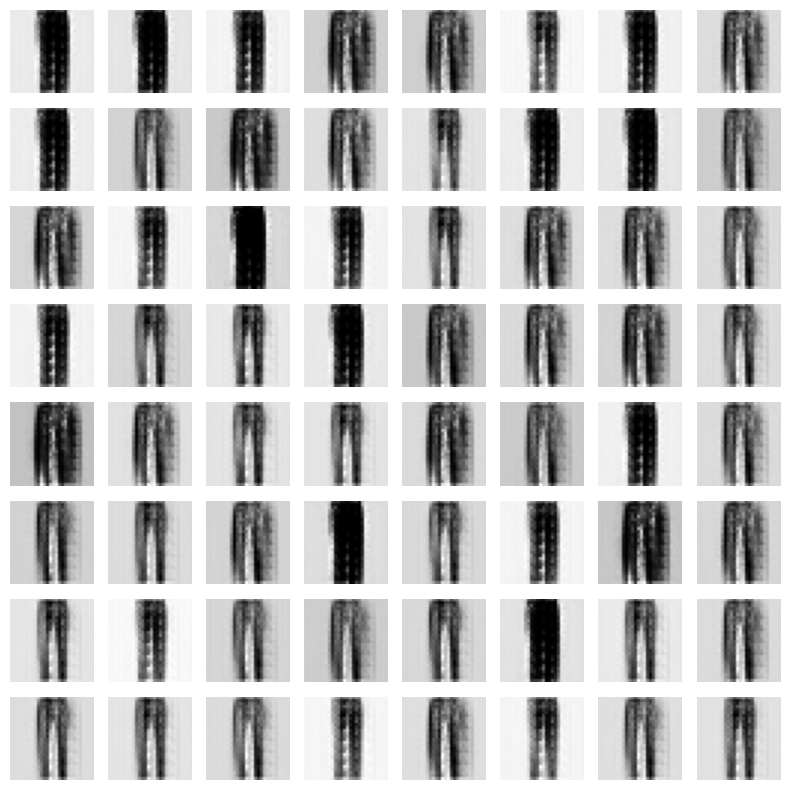

In [ ]:
for epoch in range(epochs):
  for image_batch in tqdm(X):
    g_loss, d_loss = train_step(image_batch)
  predictions = generator(seed, training=False)

  display.clear_output(wait=True)
  print(f'Epoch: {epoch+1} \t Discriminator Loss: {d_loss:.3f} \
          Generator Loss: {g_loss:.3f}')
  dsp_img = (8, 8)
  noise = np.random.normal(0, 1, size=(dsp_img[0] * dsp_img[1], noise_dim))
  show_images(noise, dsp_img)

# Workshop 2: GAN สร้างภาพ Celeb

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
import os
import gdown
from zipfile import ZipFile

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
os.makedirs("celeba_gan")

with ZipFile("/content/drive/MyDrive/Colab Notebooks/Deep Learning/img_align_celeba.zip", "r") as zipobj:
  zipobj.extractall("celeba_gan")

In [4]:
dataset = keras.preprocessing.image_dataset_from_directory("celeba_gan", label_mode=None, image_size=(64, 64), batch_size=32)
dataset = dataset.map(lambda x:x / 255.0)

Found 202599 files belonging to 1 classes.


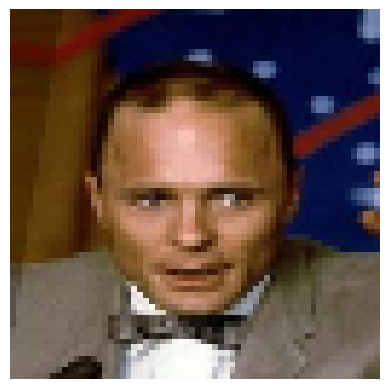

In [5]:
for x in dataset:
  plt.axis("off")
  plt.imshow(x[0])
  break

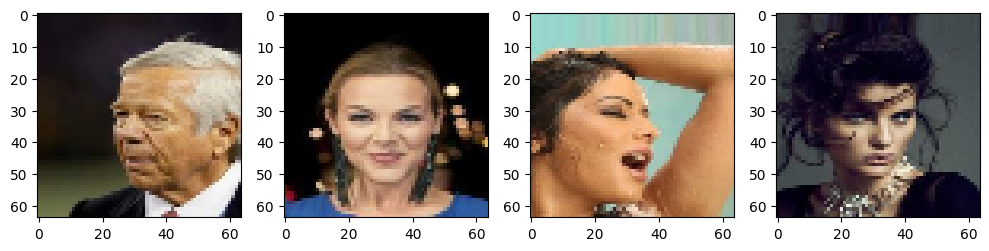

In [6]:
def plotImages(images_arr):
  fig, axes = plt.subplots(1, 4, figsize=(10, 10))
  for img, ax in zip(images_arr, axes):
    ax.imshow(img)

  plt.tight_layout()
  plt.show()

iterator = iter(dataset)
img_samples = next(iterator)[:4]
plotImages(img_samples)

## สร้าง Model

In [12]:
discriminator = keras.Sequential(
    [
        keras.Input(shape=(64, 64, 3)),
        layers.Conv2D(64, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(128, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(128, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Flatten(),
        layers.Dropout(0.2),
        layers.Dense(1, activation="sigmoid"),
    ],
    name = "discriminator",
)
discriminator.summary()

Model: "discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 32, 32, 64)        3136      
                                                                 
 leaky_re_lu_6 (LeakyReLU)   (None, 32, 32, 64)        0         
                                                                 
 conv2d_4 (Conv2D)           (None, 16, 16, 128)       131200    
                                                                 
 leaky_re_lu_7 (LeakyReLU)   (None, 16, 16, 128)       0         
                                                                 
 conv2d_5 (Conv2D)           (None, 8, 8, 128)         262272    
                                                                 
 leaky_re_lu_8 (LeakyReLU)   (None, 8, 8, 128)         0         
                                                                 
 flatten_1 (Flatten)         (None, 8192)            

In [13]:
latent_dim = 128

generator = keras.Sequential(
    [
        keras.Input(shape=(latent_dim)),
        layers.Dense(8 * 8 * 128),
        layers.Reshape((8, 8, 128)),
        layers.Conv2DTranspose(128, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2DTranspose(256, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2DTranspose(512, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2DTranspose(3, kernel_size=5, padding="same", activation="sigmoid"),
    ],
    name = "generator",
)
generator.summary()

Model: "generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 8192)              1056768   
                                                                 
 reshape_1 (Reshape)         (None, 8, 8, 128)         0         
                                                                 
 conv2d_transpose_4 (Conv2DT  (None, 16, 16, 128)      262272    
 ranspose)                                                       
                                                                 
 leaky_re_lu_9 (LeakyReLU)   (None, 16, 16, 128)       0         
                                                                 
 conv2d_transpose_5 (Conv2DT  (None, 32, 32, 256)      524544    
 ranspose)                                                       
                                                                 
 leaky_re_lu_10 (LeakyReLU)  (None, 32, 32, 256)       0 

In [14]:
class GAN(keras.Model):
  def __init__(self, discriminator, generator, latent_dim):
    super(GAN, self).__init__()
    self.discriminator = discriminator
    self.generator = generator
    self.latent_dim = latent_dim

  def compile(self, d_optimizer, g_optimizer, loss_fn):
    super(GAN, self).compile()
    self.d_optimizer = d_optimizer
    self.g_optimizer = g_optimizer
    self.loss_fn = loss_fn
    self.d_loss_metric = keras.metrics.Mean(name="d_loss")
    self.g_loss_metric = keras.metrics.Mean(name="g_loss")

  @property
  def metrics(self):
    return [self.d_loss_metric, self.g_loss_metric]

  def train_step(self, real_images):
    batch_size = tf.shape(real_images)[0]
    random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

    generated_images = self.generator(random_latent_vectors)

    combined_images = tf.concat([generated_images, real_images], axis=0)

    labels = tf.concat(
        [tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))], axis=0
    )

    labels += 0.05

    with tf.GradientTape() as tape:
      predictions = self.discriminator(combined_images)
      d_loss = self.loss_fn(labels, predictions)
    grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
    self.d_optimizer.apply_gradients(zip(grads, self.discriminator.trainable_weights))

    random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

    misleading_labels = tf.zeros((batch_size, 1))

    with tf.GradientTape() as  tape:
      predictions = self.discriminator(self.generator(random_latent_vectors))
      g_loss = self.loss_fn(misleading_labels, predictions)
    grads = tape.gradient(g_loss, self.generator.trainable_weights)
    self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))

    self.d_loss_metric.update_state(d_loss)
    self.g_loss_metric.update_state(g_loss)
    return {
        "d_loss" : self.d_loss_metric.result(),
        "g_loss" : self.g_loss_metric.result(),
    }

In [23]:
class GANMonitor(keras.callbacks.Callback):
  def __init__(self, num_img=3, latent_dim=128):
    self.num_img = num_img
    self.latent_dim = latent_dim

  def on_epoch_end(self, epoch, logs=None):
    random_latent_vectors = tf.random.normal(shape=(self.num_img, self.latent_dim))
    generated_images = self.model.generator(random_latent_vectors)
    generated_images = generated_images * 255
    generated_images.numpy()
    for i in range(self.num_img):
      img = keras.preprocessing.image.array_to_img(generated_images[i])
      img.save("generated_img_%03d_%d.png" % (epoch, i))

epochs = 1

gan = GAN(discriminator=discriminator, generator=generator, latent_dim=latent_dim)
gan.compile(
    d_optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    g_optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    loss_fn=keras.losses.BinaryCrossentropy(),
    )

In [16]:
gan.fit(dataset, epochs=epochs, callbacks=[GANMonitor(num_img=10, latent_dim=latent_dim)])

6332/6332 [==============================] - 1631s 257ms/step - d_loss: 0.6005 - g_loss: 1.3119
